# My Own Private Cluster Supremacy
(isn't related to neither "[My Own Private Idaho](https://www.imdb.com/title/tt0102494/)" nor the "[Quantum Supremacy](https://ai.googleblog.com/2019/10/quantum-supremacy-using-programmable.html)" -- this is way, way way more humble 8)

**Related to "[FIZ371 - Scientific & Technical Computations](https://github.com/emresururi/FIZ371#readme)" course | 01/06/2021**  
Emre S. Tasci, Eng. Physics Dept. Hacettepe Uni.

The adventure stemmed from a case presented by the wonderful Nick Berry in [his DataGenetics blog](https://datagenetics.com/blog/march22021/index.html):

## Six Switch Puzzle
### The Question
In summary, there are six switches numbered from 1 to 6, with each one being connected to a lamp. You roll a regular die, and toggle the switch corresponding to the roll result (if it was OFF -> ON; if it was ON -> OFF). Starting with the state where all the switches are OFF, how many, on the average, rolls are needed to lit all the lights?

### Analytical Solution
(taken almost directly from  [Nick Berry's DataGenetics blog](https://datagenetics.com/blog/march22021/index.html) with some simple explanations added)

If there are currently $n$ lit LEDs, the probability of rolling one of these lit LED is just $\tfrac{n}{6}$, the probability of rolling an unlit LED is $\tfrac{6-n}{n}$:

$$n\rightarrow\left\{\begin{array}{l} n+1,\;(Pr=\tfrac{6-n}{6}) \\  n-1,\;(Pr=\tfrac{n}{6}) \end{array}\right.$$

Define $R_n$ to represent the number of expected moves to complete the game from the state where there are currently $n$ lit LEDs on the machine.

For example, If there are five LEDs lit, there is a 1/6 chance of rolling the missing switch (this will take one roll), or there is a 5/6 chance of hitting an already lit light (which will also burn one roll, and then place us back to the state $R_4$):

$$R_5 = \frac{1}{6}[1] + \frac{5}{6}[1+R_4]$$

So, if we find ourselves where 5 LEDs are lit and if it took us $a$ moves on the average to get here, we will add a 1/6 move to the average if we manage to complete the challenge.

Moving on to 4 lit LED situation, there are two chances in six that we'll advance (take on roll and transfer us to state $R_5$), and four chances in six that we'll take on roll and end up back at state $R_3$:

$$R_4 = \frac{2}{6}[1+R_5] + \frac{4}{6}[1+R_3]$$

continuing on, we have:

$$R_3 = \frac{3}{6}[1+R_4] + \frac{3}{6}[1+R_2]$$

$$R_2 = \frac{4}{6}[1+R_3] + \frac{2}{6}[1+R_1]$$

$$R_1 = \frac{5}{6}[1+R_2] + \frac{1}{6}[1+R_0]$$

Finally, when game starts, all switches are initially OFF ($R_0$), and it’s a sure thing that we’ll take one roll and end up in state $R_1$ (the expected number of moves is one plus the expected number of moves to complete with the state with one LED lit).

$$R_0 = \frac{6}{6}[1+R_1]$$

So we have 6 equations with 6 unknowns - let's solve them:

In [1]:
import numpy as np
A = []
b = []
A.append([0, 0, 0, 0, -5/6, 1]) # R5 = ...
A.append([0, 0, 0, -4/6, 1, -2/6]) # R4 = ...
A.append([0, 0, -3/6, 1, -3/6, 0]) # R3 = ...
A.append([0, -2/6, 1, -4/6, 0, 0]) # R2 = ...
A.append([-1/6, 1, -5/6, 0, 0, 0]) # R1 = ...
A.append([1, -6/6, 0, 0, 0, 0]) # R0 = ...
b.append(1/6 + 5/6)
b.append(2/6 + 4/6)
b.append(3/6 + 3/6)
b.append(4/6 + 2/6)
b.append(5/6 + 1/6)
b.append(6/6)

R = np.linalg.solve(A,b)
for i in range(len(R)):
    print("R{:d}: {:.4f}".format(i,R[i]))


R0: 83.2000
R1: 82.2000
R2: 80.8000
R3: 78.6000
R4: 74.4000
R5: 63.0000


Average number of steps it takes to turn on all the LEDs: 83.2 (analytically)

## Monte Carlo Approach
After encountering this intriguing puzzle, I decided to solve this via Monte Carlo approach:

1. Start from all the switches OFF state.
2. Roll die until all of them are ON, count the number of tries it took to get there, write it down.
3. Restart from step 1 many times
4. Take the average of the recorded number of tries.

Here we go:

In [2]:
import numpy as np
import random

def one_run():
    counter = 0
    switches = np.full((6), False)
    #print(switches)
    while not np.all(switches):
        randi = random.randint(0,5)
        switches[randi] = not switches[randi]
        counter += 1
    #print(switches)
    return counter



In [3]:
one_run()

214

In [4]:
import time

N = 1000000
tries = []

start = time.perf_counter()
for i in range(N):
    tries.append(one_run())
finish = time.perf_counter()
print("\nFinished in {:.2f} seconds.".format(finish-start))

tries = np.array(tries)
mean = tries.mean()
print("Average number of rolls to get all-ON: {:.3f}".\
      format(mean))


Finished in 270.35 seconds.
Average number of rolls to get all-ON: 83.229


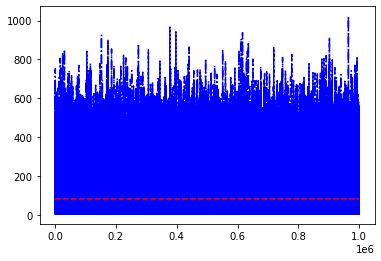

In [5]:
import matplotlib.pyplot as plt

plt.plot(range(N),tries,"-.b")
plt.plot(range(N),np.ones(N)*mean,"--r")
plt.show()

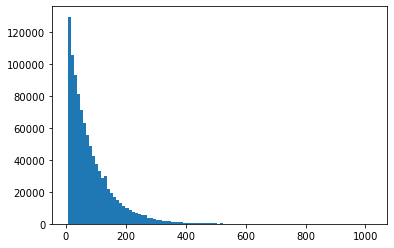

In [6]:
plt.hist(tries,bins=100)
plt.show()

There is a very nice but expensive way of seeing the fluctuation (and eventually settling(/convergence) of the mean as the number of tries increases): by re-calculating the mean at each roll which goes something like this:

```python
# I'm including this part as raw code as 
# I don't want anybody to run it unaware...

import time
means = []
start = time.perf_counter()
for i in range(N):
    means.append(tries[0:i+1].mean())
finish = time.perf_counter()

print("\nFinished in {:.2f} seconds.".format(finish-start))
# Finished in 286.60 seconds.
```

Doing the job like this for $N=1000000$ took about 5 minutes on my computer. Before we dived right into it, we could have used our brains and instead of re-calculating the mean by starting from scratch every time, we could just use the average calculated in the previous iteration:

In [8]:
import time
means = [tries[0]]
n = 1
start = time.perf_counter()
for i in range(1,N):
    this_mean = i*means[i-1]/(i+1) + tries[i]/(i+1)
    means.append(this_mean)
#print (means[-1])
finish = time.perf_counter()

print("\nFinished in {:.2f} seconds.".format(finish-start))


Finished in 0.99 seconds.


This takes about 1 second as opposed to the 5 minutes of the direct approach.

So, let's plot the plot once again, this time along with the mean calculated up to that # of tries:

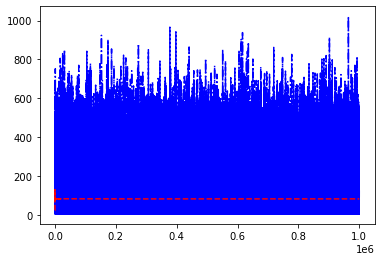

In [9]:
plt.plot(range(N),tries,"-.b")
plt.plot(range(N),means,"--r")
plt.show()

Zooming in, we have:

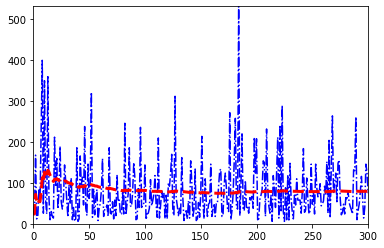

In [13]:
plt.plot(range(N),tries,"-.b")
plt.plot(range(N),means,"--r",linewidth=3.0)
plt.xlim(0,300)
plt.ylim(0,np.max(tries[0:300]))
plt.show()

So, it seems that, it settles to the expected value pretty fast.

## The Actual Story
The above were just another day at my "[FIZ371 - Scientific & Technical Computations](https://github.com/emresururi/FIZ371)" course, the actual story about the _supremacy_ starts now. 8)

I was granted a number of outdated servers by TRUBA - Turkish National Science e-Infrastructure primarily thanks to the efforts of dear Sefa. Even though the servers are not at their prime (Intel Xeon 5110 @ 1.60 GHz (6th Gen) 2 cores, 2 threads, launch date 2006 - discontinued in 2009), I had plenty of them at hand and thus they provided good means for distributed calculations such as... Monte Carlo! 8)

Around the same time I was dealing with this Six Switch Puzzle, I had acquired a new laptop (i7-10750H @ 2.60 - 5.00 GHz (10th Gen) 6 Cores, 12 threads, launch date 2020) which was just crunching anything that was fed to it! 8) So, it seemed that there was no way the cluster would triumph over the laptop. Or was there?..

### Parallelization on Laptop (single computer, multiple threads)
Python comes prepacked with nice futures about parallelization, namely the [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) module and its usage is pretty straight-forward (credit & thanks goes to Corey Schafer for his very helpful and clear tutorial on [multiprocessing](https://www.youtube.com/watch?v=fKl2JW_qrso) (as well as [threading](https://www.youtube.com/watch?v=IEEhzQoKtQU)).

So executing $N=1000000$ trials as distributed to 10 threads as 100000 trials on each goes like this:

In [14]:
import concurrent.futures
import time

import numpy as np
import random

n_threads = 10
N_runs_per_thread = 100000

def N_run(N=1):
    runs = []
    for i in range(N):
        counter = 0
        switches = np.full((6), False)
        #print(switches)
        while np.sum(switches) != 6:
            randi = random.randint(0,5)
            switches[randi] = not switches[randi]
            counter += 1
        #print(switches)
        runs.append(counter)
    return runs


tries = []

start = time.perf_counter()

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = [executor.submit(N_run,N_runs_per_thread) \
               for _ in range(n_threads)]

    for f in concurrent.futures.as_completed(results):
        tries.extend(f.result())

tries = np.array(tries)
print("Calculated mean: {:.3f}".format(tries.mean()))
print("Total number of runs: {:d}".format(len(tries)))
finish = time.perf_counter()

print("\nFinished in {:.2f} seconds.".format(finish-start))

Calculated mean: 83.196
Total number of runs: 1000000

Finished in 79.36 seconds.


It takes a total of 80 seconds: the performance is not ideally linearized $(80\times10 \gg 270)$ but still good.

## Parallelization on Cluster (multiple computers, multiple threads)
Turns out that concurrent.futures are written mostly for a single computer with multiple CPUs in mind. When it came to parallelization/distribution over a cluster, after some search, I came up with the [scoop](https://github.com/soravux/scoop/). For workload management on the cluster, I had installed [slurm](https://slurm.schedmd.com/overview.html) and scoop worked directly in compatibility with slurm (except the fact that most of the time couldn't close the workers thus the completed job had to be canceled manually):

### The code: sixswitch.py

```python
from scoop import futures
import time
 
import numpy as np
import random
import os
 
N_runs_per_thread = 1000
 
def one_run(N=1):
    runs = []
    for i in range(N):
        counter = 0
        switches = np.full((6), False)
        #print(switches)
        while np.sum(switches) != 6:
            randi = random.randint(0,5)
            switches[randi] = not switches[randi]
            counter += 1
        #print(switches)
        runs.append(counter)
    return runs
 
if __name__ == '__main__':
    results = []
    futuress = []
    start = time.perf_counter()
    print("scoop size",scoop.SIZE)
    results.extend(futures.map(one_run,[N_runs_per_thread]*scoop.SIZE))
    #print(results)   
    results_flat = [item for sublist in results for item in sublist]
    results = results_flat
    #print(len(results))
    tries = np.array(results)
    print(tries.mean())
    print(len(tries))
 
    finish = time.perf_counter()
 
    print("Finished in {:.2f} seconds.".format(finish-start))
 ```

### Submit batch: submit.sh

```bash
#!/bin/bash
#
#SBATCH --job-name=SixSwitch
#SBATCH --output=out_%A_%a.txt
#
#SBATCH --ntasks=36
 
# Start scoop with python input script
hosts=$(srun bash -c hostname)
python -m scoop --host $hosts -vv sixswitch.py
```

### Submitting and result:
```bash
$ sbatch submit.sh 
Submitted batch job 1069

$ ls
out_1069_4294967294.txt  sixswitch.py  submit.sh

$ grep -v "^\[" out_1069_4294967294.txt 
scoop size 36
82.92027777777778
36000
Finished in 6.34 seconds.
```

# And here comes the supremacy!..
3600000 (3 million and 6 hundred thousand) trials to achieve 6 OFF switches to all ON, and calculating the average number of tries it took to reach to all ON:

* **Distributed as 12 x 300000 on my laptop:**  
  ```83.21493277777778
  3600000
  Finished in 303.21 seconds.```
* **Distributed as 36 x 100000 on the cluster:**  
  ```scoop size 36
  83.18045111111111
  3600000
  Finished in 220.83 seconds.```

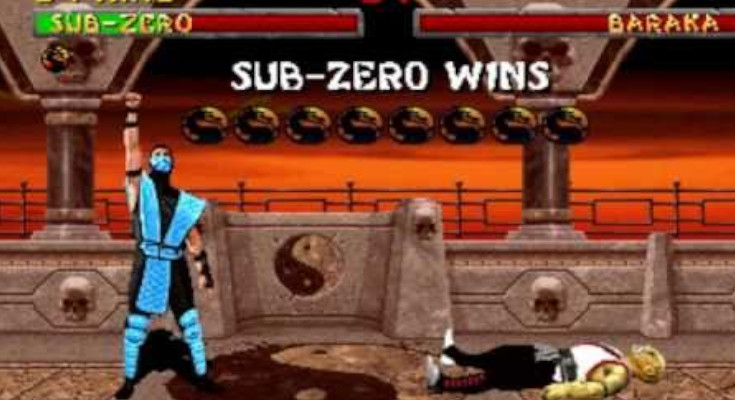
[Image: [Mortal Kombat](https://www.funstockretro.co.uk/news/5-things-you-didnt-know-about-sub-zero-mortal-kombat/)]